In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown as md

In [3]:
import process_interferometry 
process_interferometry.run_for_retroActions_shots()

processing shots:   0%|          | 0/1181 [00:00<?, ?it/s]

In [3]:
# read pickle file
# no need to rearange index and parse datetime values

df = pd.read_pickle('InterferometryDF.pkl',)
df.n_bad_peaks.apply(pd.to_numeric);
#df

In [4]:
# Filter shots witouth plasma and with incomplete interferometry data
df = df[(df.has_complete_interferometry_data == True) & (df.is_plasma == True)]

### Resutls:

In [5]:
validity = lambda x : x.astype(bool).sum() / x.size * 100.


validity_analog  = validity(df.density_analog_valid)
validity_original = validity(df.density_original_valid)
validity_no_fix = validity(df.density_no_fix_valid)
validity_fix = validity(df.density_fix_valid)


md("""
Processed %d shots from [RetroActions](https://golem.fjfi.cvut.cz/RetroActions/1122Interferometry):
- %.2f%% of analog processed density is valid  
- %.2f%% of original digitally processed density is valid  
- %.2f%% of digitally non-fixed (new alg)  density is valid  
- %.2f%% of digitally fixed  density is valid  
""" % (len(df), validity_analog, validity_original, validity_no_fix, validity_fix))


Processed 1015 shots from [RetroActions](https://golem.fjfi.cvut.cz/RetroActions/1122Interferometry):
- 0.10% of analog processed density is valid  
- 14.78% of original digitally processed density is valid  
- 17.54% of digitally non-fixed (new alg)  density is valid  
- 77.93% of digitally fixed  density is valid  


------------
### Error and time 
(relative time in session)

In [6]:
from  process_interferometry import *

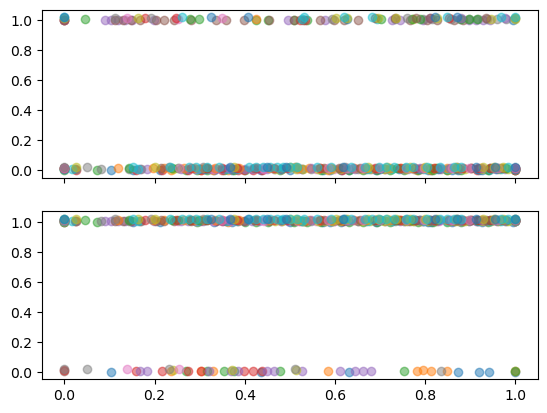

In [7]:
groups = df.groupby('session')

fig, (ax, ax2) = plt.subplots(nrows = 2, sharex = True)
offset = 0.


for group, group_df in groups:
    if group_df.time.count() < 10:
        continue
    if np.all(group_df.density_original_valid == False):
        continue
    
    time = (group_df.time - group_df.time.iat[0])
    time_sess_length = (group_df.time.iat[-1] - group_df.time.iat[0]).total_seconds()
    time_sec = time.apply(lambda x : x.total_seconds())
    time_scaled = time_sec / time_sess_length


    digital = group_df.density_original_valid.astype(int) + offset
    offset += .001
    ax.scatter(time_scaled, digital, alpha = .5)
    
    group_df.density_fix_valid.fillna(value=False, inplace=True)
    digital_fix  = group_df.density_fix_valid.astype(int) + offset
    ax2.scatter(time_scaled, digital_fix, alpha = .5)

### Histogram of number of repairs

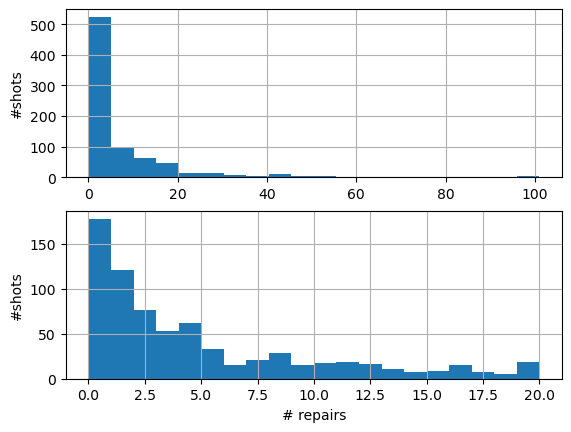

In [8]:
fixed = df[df.density_fix_valid == True]
fixed = fixed.sort_values('n_bad_peaks')
fig, (ax,ax2) = plt.subplots(2)
fixed.n_bad_peaks.hist(bins = 20, ax = ax)#, range = (0,30))
fixed.n_bad_peaks.hist(bins = 20, ax = ax2, range = (0,20))
ax.set_ylabel("#shots")
ax2.set_ylabel("#shots")
ax2.set_xlabel("# repairs")
plt.show()

In [9]:
count, edges = np.histogram(fixed.n_bad_peaks, bins=fixed.n_bad_peaks.max())
count = np.cumsum(count) / df.n_bad_peaks.count() *100
fig, (ax,ax2) = plt.subplots(2)
ax.stairs(count, edges)
ax2.stairs(count, edges)
ax2.set_xlim(-.5,11)
ax2.set_xlabel('# repairs')
ax.set_ylabel('validity [%]');
ax2.set_ylabel('validity [%]');

### Plasma parameters

/home/marek/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


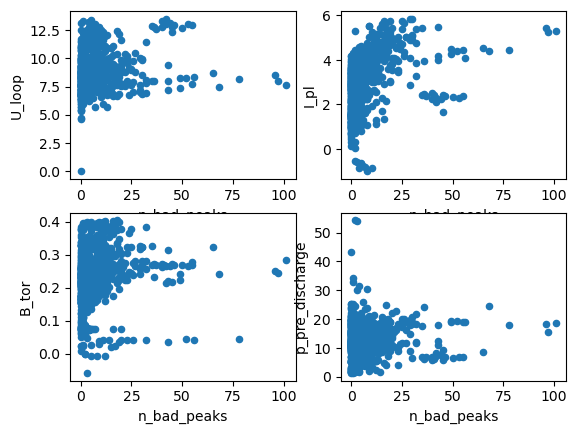

In [10]:
fixed_slice = fixed[["U_loop", "I_pl", "B_tor", "p_pre_discharge","n_bad_peaks"]]
fig, axs = plt.subplots(2,2)
axs = axs.flatten()
for ax, col in zip(axs,fixed_slice.columns[:-1]):
    fixed_slice.plot.scatter(x = 'n_bad_peaks', y = col, ax = ax)

In [11]:
#--------
#
# Some plots for tuning and testing parameters

In [12]:
def adv_plot(shot_no:int, ax : plt.Axes = None, kind : str = 'digital', add_info = True, **kargs):
    if not ax:
        fig, ax = plt.subplots()
    shot_data = get_shot_data(shot_no)
    
    if kind  == 'digital':
        density = shot_data.digital_interferometer_original
    elif kind == "analog" :
        density  = shot_data.analog_interferometer
    elif kind == 'digital_fixed' :
        shot_data.compute_corrected_density()
        density  = shot_data.digital_interferometer_new_fixed
    elif kind == 'digital_nofix':
        shot_data.compute_corrected_density()
        density = shot_data.digital_interferometer_new_no_fix
    elif kind == 'digital_fixed_all_vars':
        shot_data.compute_corrected_density(recompute = True)
        density = shot_data.digital_interferometer_fixed_vars
    if density is None:
        print('returning empty plot')
        return ax
    
    density = density if isinstance(density, list) else [density]
    for d in density:
        d.plot(ax = ax, **kargs)
    density = density[0]
    
    if not add_info:
        return ax
    threshold = density.max() * .05
    threshold = np.max([5e16,threshold]) 
    
    step = .5
    if shot_data.is_plasma:
        s_end = density.index[-1] - shot_data.plasma_end
    else:
        s_end = 5
    for t_slice in np.arange(0,s_end,step)[:-2]:
        t_start = density.index[-1] - t_slice - step
        t_end  = density.index[-1] - t_slice
        is_zero = is_zero_in_slice(density, threshold=threshold, 
                                 start = t_start, end = t_end)
        color = '#ABB2B9' if is_zero else "#E74C3C"
        ax.axvspan(t_start,t_end, color = color, alpha = .5)
    if shot_data.is_plasma:
        if kind  == 'digital':
            negative = df.loc[shot_no].positive_original
        elif kind == "analog" :
            negative = df.loc[shot_no].positive_analog
        elif kind == 'digital_fixed' :
            negative = df.loc[shot_no].positive_fix

        
#         ax.text(0.25, 0.25, f'{negative:.1f}%>0', horizontalalignment='center',
#                 verticalalignment='center', transform=ax.transAxes,
#                 bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=1'))

        ax.axvline(shot_data.plasma_start, c = 'green')
        ax.axvline(shot_data.plasma_end , c = 'green')
        
    ax.axhline(0, c = 'k', ls = '--')
    
    return ax

### Repair variants
- black -- final version
- dotted -- without fix

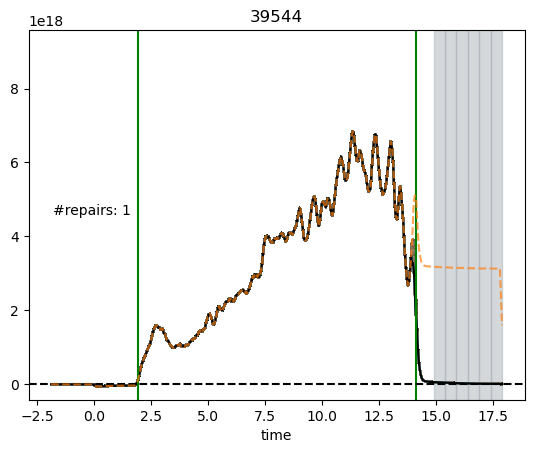

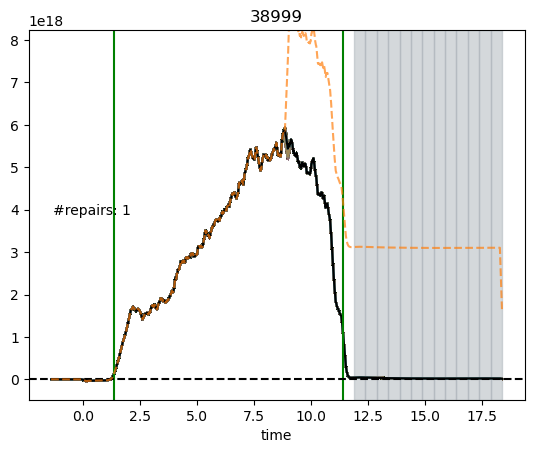

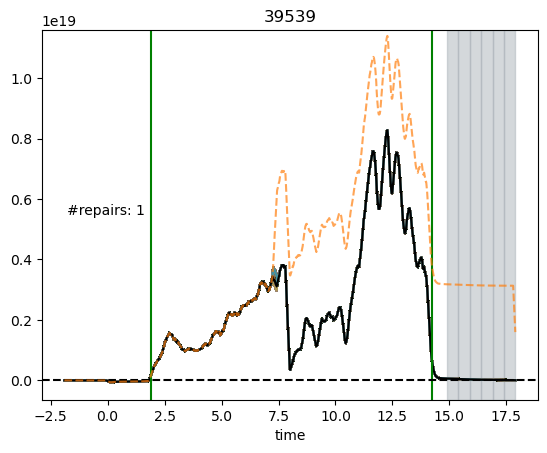

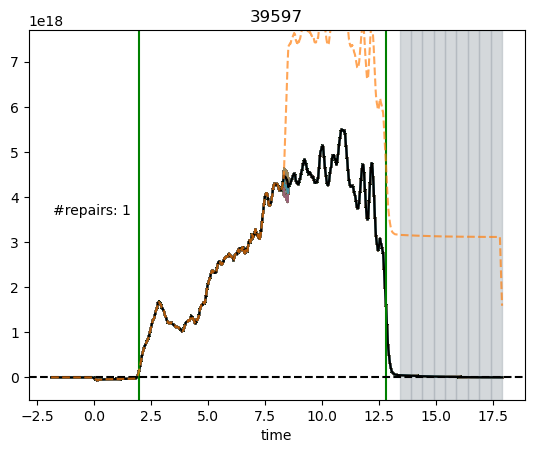

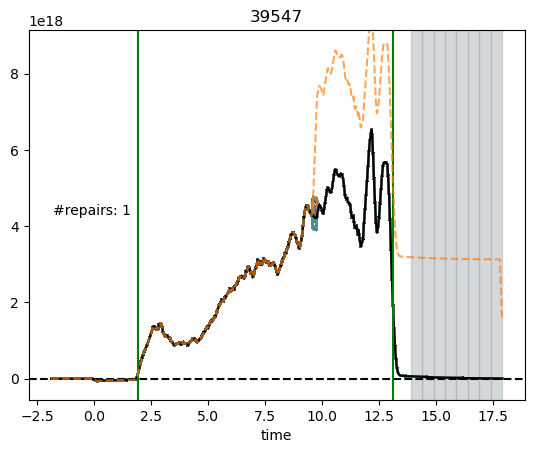

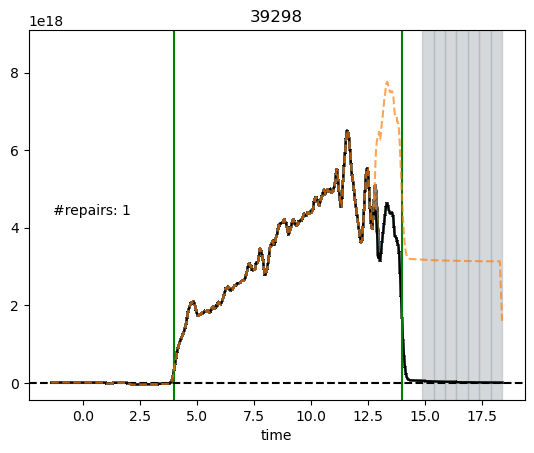

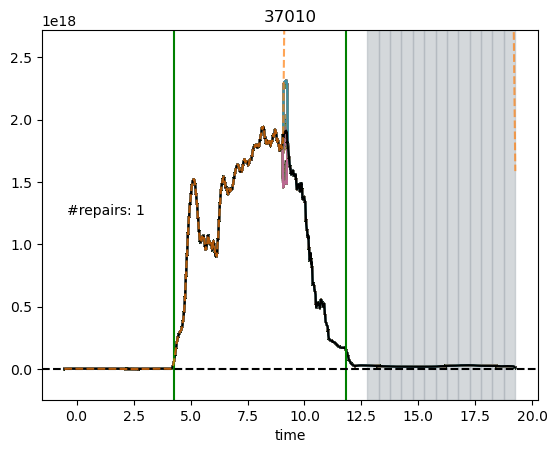

In [16]:
for shot_no in fixed[fixed.n_bad_peaks>=1].index[:100:10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed_all_vars', add_info=False, alpha = .5)
    adv_plot(shot_no, kind = 'digital_fixed',ax = ax, add_info=True, color = 'k')
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, alpha = .7, ls = '--')
    ax.set_title(shot_no)
    ax.text(.05,.5, f"#repairs: {fixed.loc[shot_no].n_bad_peaks}", transform=ax.transAxes,)
    shot_data = get_shot_data(shot_no)
    shot_data.compute_corrected_density()
    ax.set_ylim(top = shot_data.digital_interferometer_new_fixed.max()*1.4)
    plt.show()

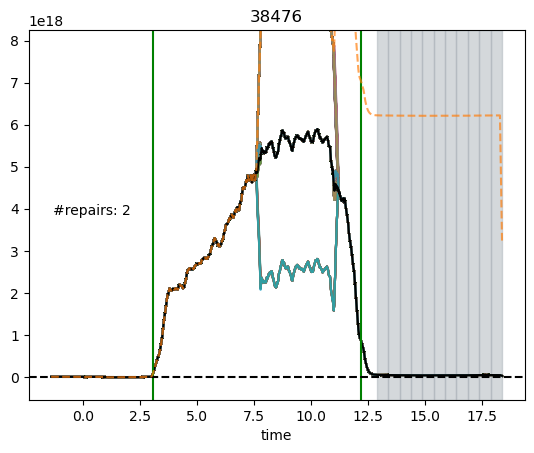

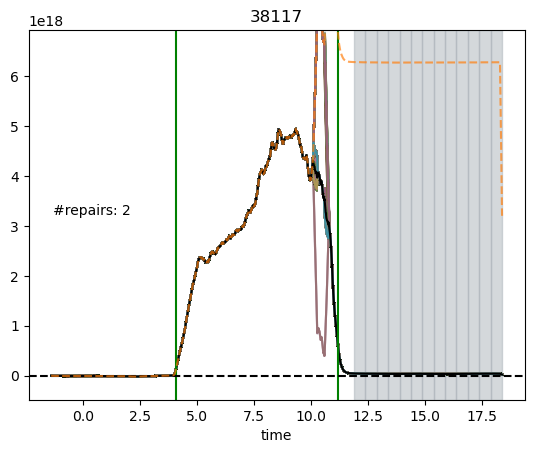

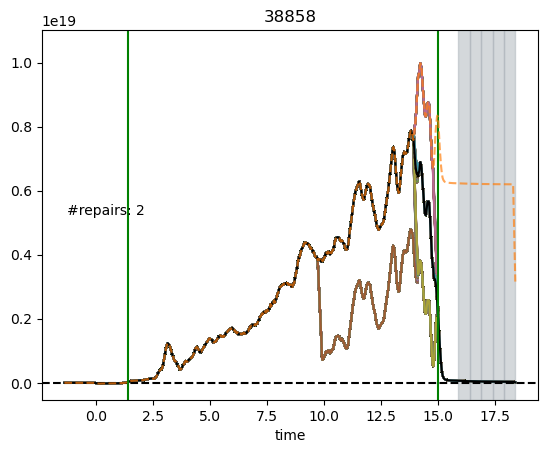

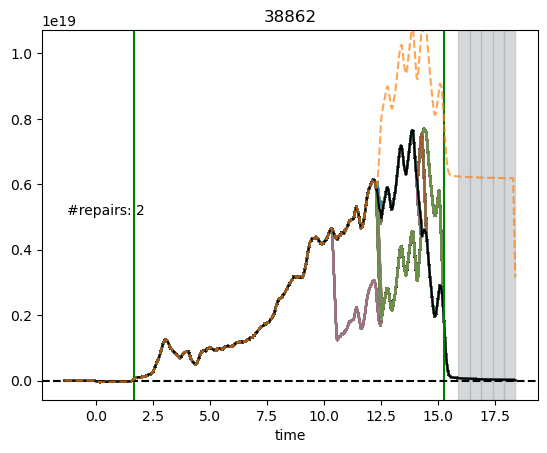

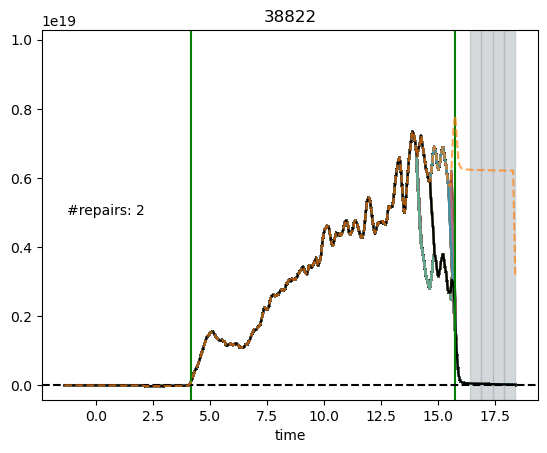

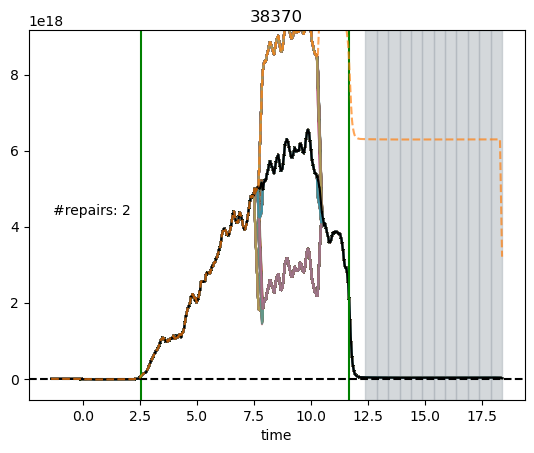

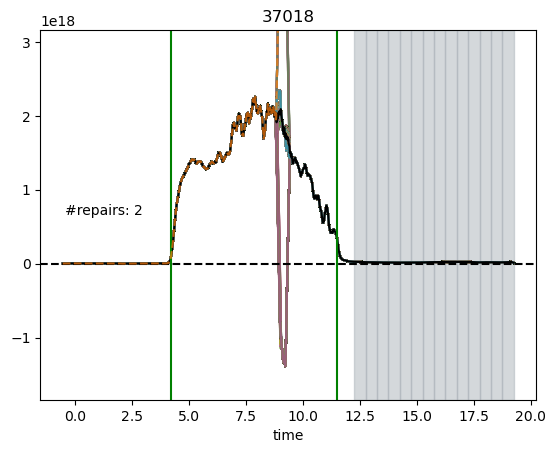

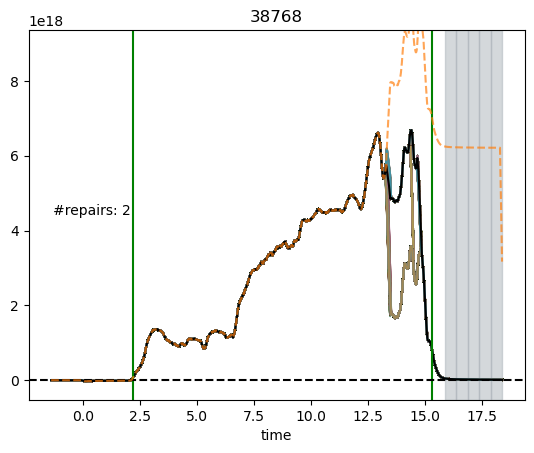

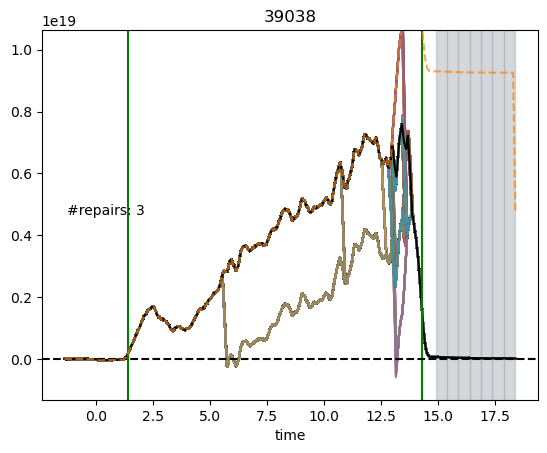

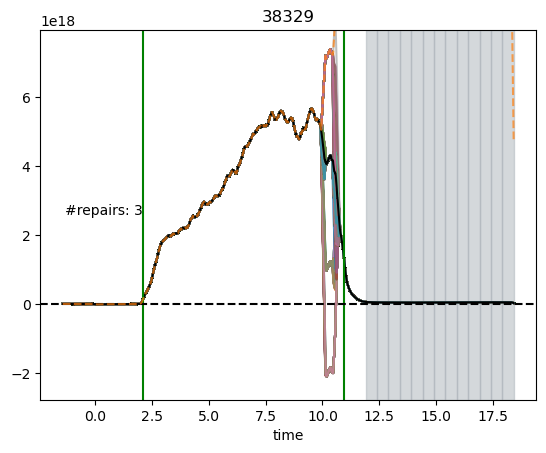

In [13]:
#print(len(fixed))
for shot_no in fixed[fixed.n_bad_peaks>=2].index[:100:10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed_all_vars', add_info=False, alpha = .5)
    adv_plot(shot_no, kind = 'digital_fixed',ax = ax, add_info=True, color = 'k')
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, alpha = .7, ls = '--')
    ax.set_title(shot_no)
    ax.text(.05,.5, f"#repairs: {fixed.loc[shot_no].n_bad_peaks}", transform=ax.transAxes,)
    shot_data = get_shot_data(shot_no)
    shot_data.compute_corrected_density()
    ax.set_ylim(top = shot_data.digital_interferometer_new_fixed.max()*1.4)
    plt.show()

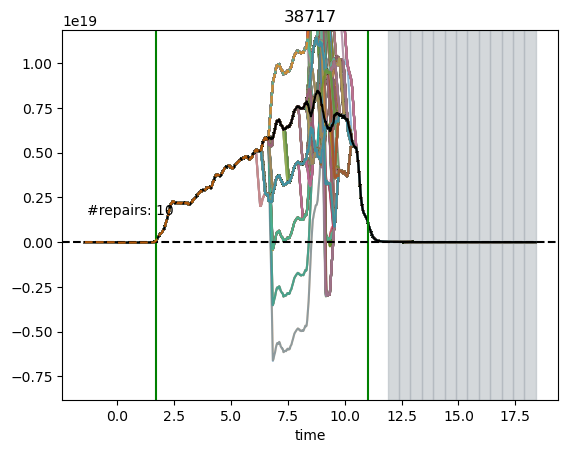

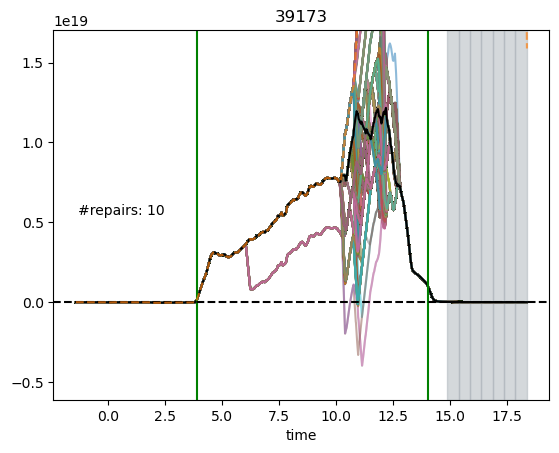

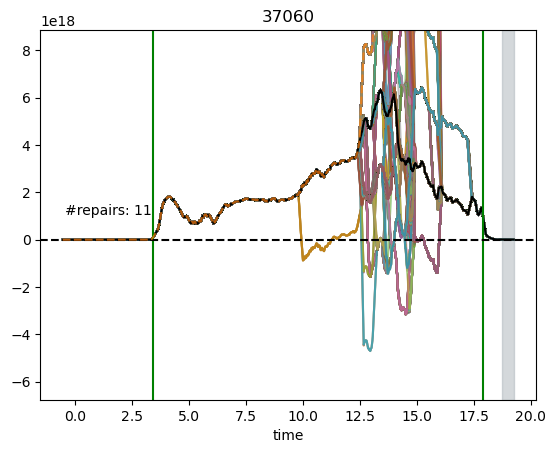

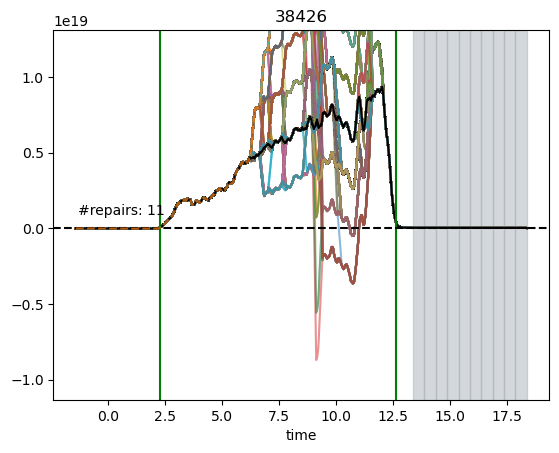

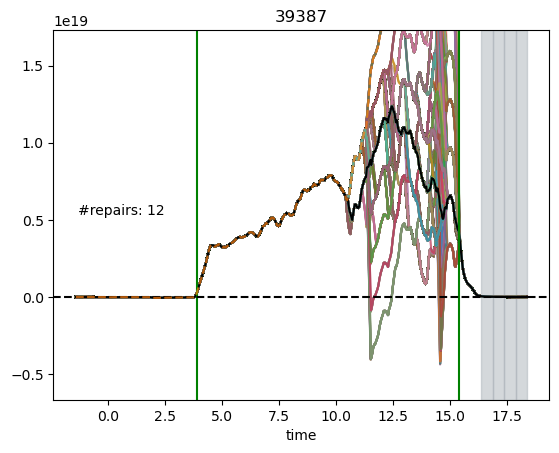

In [14]:
#print(len(fixed))
for shot_no in fixed[fixed.n_bad_peaks>=10].index[:50:10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed_all_vars', add_info=False, alpha = .5)
    adv_plot(shot_no, kind = 'digital_fixed',ax = ax, add_info=True, color = 'k')
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, alpha = .7, ls = '--')
    ax.set_title(shot_no)
    ax.text(.05,.5, f"#repairs: {fixed.loc[shot_no].n_bad_peaks}", transform=ax.transAxes,)
    shot_data = get_shot_data(shot_no)
    shot_data.compute_corrected_density()
    ax.set_ylim(top = shot_data.digital_interferometer_new_fixed.max()*1.4)
    plt.show()

In [ ]:
for shot_no in fixed[fixed.n_bad_peaks>=10].index[-50::10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed_all_vars', add_info=False, alpha = .5)
    adv_plot(shot_no, kind = 'digital_fixed',ax = ax, add_info=True, color = 'k')
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, alpha = .7, ls = '--')
    ax.set_title(shot_no)
    ax.text(.05,.5, f"#repairs: {fixed.loc[shot_no].n_bad_peaks}", transform=ax.transAxes,)
    shot_data = get_shot_data(shot_no)
    shot_data.compute_corrected_density()
    ax.set_ylim(top = shot_data.digital_interferometer_new_fixed.max()*1.4)
    plt.show()

In [ ]:
fixed_bad = df[(df.density_fix_valid == True) & (df.is_plasma)]
fixed_bad = fixed_bad.sort_values('n_bad_peaks')
print(len(fixed_bad))
for shot_no in fixed_bad.index[:10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed_all_vars', add_info=False, alpha = .5)
    adv_plot(shot_no, kind = 'digital_fixed',ax = ax, add_info=True, color = 'k')
    adv_plot(shot_no, kind = 'digital_nofix', ax = ax, add_info=False, alpha = .7, ls = '--')
    ax.set_title(shot_no)
    #ax.text(.2,.5, f"{fixed_bad.loc[shot_no].n_bad_peaks} fixes")
    shot_data = get_shot_data(shot_no)
    shot_data.compute_corrected_density()
    #ax.set_ylim(top = shot_data.digital_interferometer_new_fixed.max()*1.4)
    plt.show()

In [ ]:
for shot_no in df[df.density_analog == True].index:
    ax = adv_plot(shot_no, kind = 'analog')
    ax.set_title(shot_no)

In [ ]:
for shot_no in df[(df.density_original_valid == True) ].index: # & (df.zero_digital == True)
    ax = adv_plot(shot_no)
    if ax: 
        ax.set_title(shot_no)

In [ ]:
for shot_no in df[(df.density_fix == False) & (df.density_digital == False)].index[::10]:
    ax = adv_plot(shot_no, kind = 'digital_fixed')
    adv_plot(shot_no, kind = 'digital', ax = ax, add_info=False)
    ax.set_title(shot_no)
    plt.show()

In [ ]:
for shot_no in df[df.density_fix == False].index:
    ax = adv_plot(shot_no, kind = 'digital_fixed')
    ax.set_title(shot_no)